In [ ]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.include import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
latt_size = (16, 16, 16, 16)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
# mass = 0.05
# mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True


    @@@@@@######QCU NOTES START######@@@@@@@
    Guide:
    0. Required: MPI(e.g. 4.1.2), CUDA(e.g. 12.4), CMAKE(e.g. 3.22.1), GCC(e.g. 11.4.0), HDF5-MPI(e.g. 1.10.7,'apt install libhdf5-mpi-dev && export HDF5_MPI="ON" && pip install --no-binary=h5py h5py').
    1. The libqcu.so was compiled when pyqcu setup in download_path/PyQCU/lib, please add this path to your LD_LIBRARY_PATH.
    2. The QCU(PyQCU) splite grid by x->y->z->t, lattice by x->y->z->t->p->d[x,y,z,t]->c->c or x->y->z->t->c->s(->p) and x->y->z->t->c->s->c->s(->p).
    3. The QUDA(PyQUDA) splite grid by t->z->y->x, lattice by c->c->x->y->z->t->p->d[x,y,z,t] or c->s->x->y->z->t(->p) and c->s->c->s->x->y->z->t(->p).
    4. The QCU input params in numpy array(dtype=np.int32), argv in  numpy array(dtype=np.float32 or float64) array, set_ptrs in numpy array(dtype=np.int64), other in cupy array(dtype=cp.complex64 or complex128).
    5. The smallest lattice size is (wilson:x=4,y=4,z=4,t=4;clover:x=8,y=8,z=8,t=8) that QCU support

In [35]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.1730434272736335e-16


In [3]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U=U,
                clover=clover, clover_term=clover.add_I(clover_term=clover_term), verbose=verbose, max_iter=50,max_levels=5)

self.dof_list:[12, 24, 8, 4, 4, 8, 8, 8, 4, 12, 12, 12, 8, 4, 2, 4, 4, 24, 12, 12, 12, 4, 4, 4, 4, 4]
Building grid list:
  Level 0: 16x16x16x16
  Level 1: 8x8x8x8
  Level 2: 4x4x4x4
self.grid_list:[[16, 16, 16, 16], [8, 8, 8, 8], [4, 4, 4, 4]]
Norm of b:1.1214332175006505
Norm of r:1.1214332175006505
Norm of x0:0.0
BICGSTAB-Iteration 0: Residual = 1.934631e-01, Time = 0.052191 s
BICGSTAB-Iteration 1: Residual = 6.392724e-02, Time = 0.051570 s
BICGSTAB-Iteration 2: Residual = 1.270226e-01, Time = 0.051920 s
BICGSTAB-Iteration 3: Residual = 2.154721e-02, Time = 0.051613 s
BICGSTAB-Iteration 4: Residual = 1.727070e-02, Time = 0.052010 s
BICGSTAB-Iteration 5: Residual = 9.424864e-03, Time = 0.051710 s
BICGSTAB-Iteration 6: Residual = 6.467579e-03, Time = 0.051840 s
BICGSTAB-Iteration 7: Residual = 9.468099e-03, Time = 0.052088 s
BICGSTAB-Iteration 8: Residual = 8.059373e-03, Time = 0.051943 s
BICGSTAB-Iteration 9: Residual = 6.475501e-03, Time = 0.051742 s
BICGSTAB-Iteration 10: Residual 

In [4]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [34]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 3.43 ms, sys: 0 ns, total: 3.43 ms
Wall time: 2.8 ms
CPU times: user 1.42 ms, sys: 35 μs, total: 1.46 ms
Wall time: 1.42 ms
886.8100134752651
42.62161161814855
995.3212618518644
995.3212618518644
1.7423617533260315e-16
CPU times: user 237 ms, sys: 60 μs, total: 237 ms
Wall time: 235 ms


In [29]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 4.48 ms, sys: 7 μs, total: 4.49 ms
Wall time: 3.82 ms
CPU times: user 1.62 ms, sys: 40 μs, total: 1.66 ms
Wall time: 1.53 ms


In [8]:
b0 = mg.b_list[0]
b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
_b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
_b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
print(_b1.flatten()[:100]/b1.flatten()[:100])

restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
prolong:shape,fine_dof:(torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
tensor([1.0000+1.4941e-16j, 1.0000+4.8991e-16j, 1.0000+1.4701e-16j,
        1.0000-3.9880e-16j, 1.0000-1.3995e-15j, 1.0000-3.1207e-16j,
        1.0000-4.1317e-16j, 1.0000-4.5254e-18j, 1.0000+2.7993e-17j,
        1.0000+1.9542e-17j, 1.0000-4.4333e-16j, 1.0000+2.9816e-16j,
        1.0000-2.5956e-16j, 1.0000-1.7027e-16j, 1.0000+2.2483e-16j,
        1.0000+9.2456e-17j, 1.0000+9.1778e-17j, 1.0000-2.0375e-16j,
        1.0000+3.4848e-17j, 1.0000+9.2237e-18j, 1.0000+2.8985e-17j,
        1.0000+1.5992e-16j, 1.0000+1.3908e-16j, 1.0000-1.0939e-16j,
        1.0000+3.1413e-16j, 1.0000+3.0544e-17j, 1.0000+6.4484e-17j,
        1.0000-1.5074e-17j, 1.0000-1.4575e-16j, 1.0000-2.8884e-16j,
        

In [9]:
# _x = inverse.cg(b=b, matvec=matvec, verbose=verbose)
_x = inverse.bicgstab(b=b, matvec=_matvec, verbose=verbose)
# _x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, verbose=verbose)

Norm of b:887.1781621292079
Norm of r:1333.3285475797618
Norm of x0:887.5271516441018
BICGSTAB-Iteration 0: Residual = 2.884357e+02, Time = 0.053217 s
BICGSTAB-Iteration 1: Residual = 1.261229e+02, Time = 0.052470 s
BICGSTAB-Iteration 2: Residual = 1.245199e+02, Time = 0.051928 s
BICGSTAB-Iteration 3: Residual = 8.414471e+01, Time = 0.052614 s
BICGSTAB-Iteration 4: Residual = 5.328978e+01, Time = 0.052367 s
BICGSTAB-Iteration 5: Residual = 6.360496e+01, Time = 0.052034 s
BICGSTAB-Iteration 6: Residual = 3.047733e+01, Time = 0.052425 s
BICGSTAB-Iteration 7: Residual = 5.192510e+01, Time = 0.052076 s
BICGSTAB-Iteration 8: Residual = 4.792116e+01, Time = 0.052520 s
BICGSTAB-Iteration 9: Residual = 1.061048e+02, Time = 0.052686 s
BICGSTAB-Iteration 10: Residual = 3.891209e+01, Time = 0.055314 s
BICGSTAB-Iteration 11: Residual = 5.637087e+01, Time = 0.054082 s
BICGSTAB-Iteration 12: Residual = 1.008426e+02, Time = 0.052161 s
BICGSTAB-Iteration 13: Residual = 1.856282e+01, Time = 0.052541 s


MG-0:Norm of b:887.1781621292079
MG-0:Norm of r:887.1781621292079
MG-0:Norm of x0:0.0
B-MG-0-BICGSTAB-Iteration 0: Residual = 2.283472e+02
restrict:shape,coarse_dof:(torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-1:Norm of b:131.11806189111962
MG-1:Norm of r:131.11806189111962
MG-1:Norm of x0:0.0
B-MG-1-BICGSTAB-Iteration 0: Residual = 1.176753e+00
restrict:shape,coarse_dof:(torch.Size([8, 24, 4, 2, 4, 2, 4, 2, 4, 2]), 8)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-2:Norm of b:0.27090391854298196
MG-2:Norm of r:0.27090391854298196
MG-2:Norm of x0:0.0
B-MG-2-BICGSTAB-Iteration 0: Residual = 5.636772e-05
F-MG-2-BICGSTAB-Iteration 0: Residual = 5.636772e-05, Time = 0.006199 s
Converged at iteration 0 with residual 5.636772e-05

Performance Statistics:
Total iterations: 1
Total time: 0.006219 seconds
Average time per iteration: 0.006199 s
Final residual: 5.64e-05
prolong:shape,fine_dof:(torch.Size([8, 24, 4, 2, 4, 2, 4, 2, 4, 2]), 24)
EeTtZzYyXx,ETZYX->eTtZzYyXx
F-MG-1

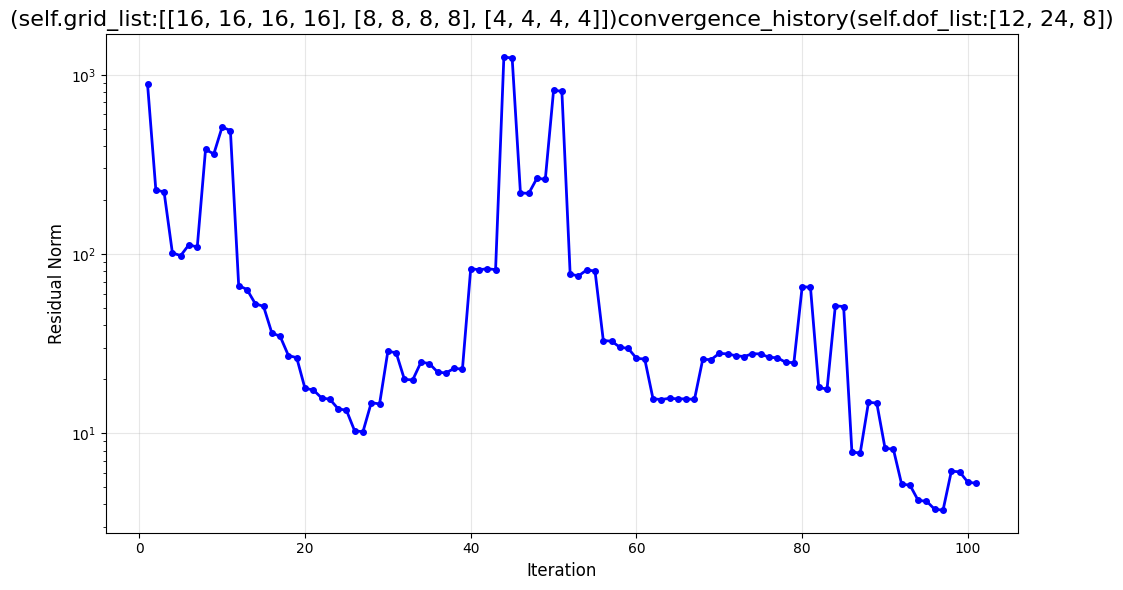

In [10]:
x = mg.solve()
mg.plot()

In [11]:
mg.lonv_list[0].shape

torch.Size([24, 12, 8, 2, 8, 2, 8, 2, 8, 2])

In [12]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([ 1.4289e-04+1.4313e-03j,  2.3694e-03+1.5177e-03j,
        -2.0676e-03+4.4831e-03j,  2.4683e-03+3.6976e-03j,
        -1.9043e-03+5.7736e-03j,  1.6245e-03+4.9433e-03j,
        -1.7794e-04+6.6898e-03j,  9.0233e-04+6.7524e-03j,
        -3.6677e-04+6.6612e-03j,  1.3599e-03+3.9660e-03j,
         9.2582e-04+5.6253e-03j,  2.8180e-03+2.6919e-03j,
         2.1940e-03+3.0744e-03j,  2.2809e-03+1.0114e-03j,
         1.1891e-03+1.5166e-03j,  3.3234e-03+4.1164e-04j,
         6.4606e-03+1.8778e-03j,  2.4656e-03+3.3615e-03j,
         7.4631e-03+2.7917e-03j, -6.8649e-04+4.4050e-03j,
         5.1199e-03+4.0849e-03j, -2.1527e-06+5.5476e-03j,
         3.8220e-03+4.7780e-03j,  1.5621e-03+6.0748e-03j,
         1.1216e-03+5.3006e-03j,  2.5172e-03+6.4007e-03j,
         2.9177e-03+3.5422e-03j,  3.1398e-03+3.9504e-03j,
         3.6308e-03+1.7471e-03j,  3.5087e-03+1.8253e-03j,
         4.4603e-03-2.8799e-04j,  3.5223e-03+1.1554e-03j,
         2.9220e-03+2.4116e-03j,  6.5779e-03+1.9648e-03j,
         1.879

In [13]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

0.1441756648862009


In [14]:
mg.num_levels

3

In [15]:
index = -1
mg.u_list[index] = inverse.bicgstab(b=torch.ones_like(mg.b_list[index]),
                                 matvec=mg.op_list[index].matvec, verbose=verbose,max_iter=10000)

Norm of b:45.254833995939045
Norm of r:644.7933837916687
Norm of x0:45.32766409587698
BICGSTAB-Iteration 0: Residual = 1.319192e-01, Time = 0.002500 s
BICGSTAB-Iteration 1: Residual = 3.426891e-05, Time = 0.002537 s
BICGSTAB-Iteration 2: Residual = 1.196505e-08, Time = 0.004123 s
Converged at iteration 2 with residual 1.196505e-08

Performance Statistics:
Total iterations: 3
Total time: 0.009318 seconds
Average time per iteration: 0.003053 s
Final residual: 1.20e-08
